In [ ]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 67 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2022-05-17 23:50:16--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  26.0MB/s    in 11s     

2022-05-17 23:50:27 (24.4 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [ ]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
import pyspark
import numpy as np
import pandas as pd

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('data').getOrCreate()
data = spark.read.csv('Classification.csv', sep=',', header=True, inferSchema=True, nullValue='NA')
data.show(5)

+------+----------+-----------+------------+-----+----------------+
|teamId|      name|   strength|currentLevel|price|strengthCategory|
+------+----------+-----------+------------+-----+----------------+
|    79|   O1uJX7C|0.774473575|           1|    0|            Weak|
|    92|  WeLHp8HZ|0.171926026|           1|    0|            Weak|
|     6|    mARlfz|0.537353044|           1|    0|            Weak|
|     7|xO41jlAo0Y|0.394370371|           1|    0|            Weak|
|    40|   vdwO0k1|0.706832959|           1|    0|            Weak|
+------+----------+-----------+------------+-----+----------------+
only showing top 5 rows



In [ ]:
data.show(10)

+------+----------+-----------+------------+-----+----------------+
|teamId|      name|   strength|currentLevel|price|strengthCategory|
+------+----------+-----------+------------+-----+----------------+
|    79|   O1uJX7C|0.774473575|           1|    0|            Weak|
|    92|  WeLHp8HZ|0.171926026|           1|    0|            Weak|
|     6|    mARlfz|0.537353044|           1|    0|            Weak|
|     7|xO41jlAo0Y|0.394370371|           1|    0|            Weak|
|    40|   vdwO0k1|0.706832959|           1|    0|            Weak|
|    18| VpF5Lrtz7|0.885469892|           1|  421|          Strong|
|    91| 8brfgFZi6|0.478092156|           1|    0|            Weak|
|    90| 0sicoF7Pl|0.443162419|           1|  388|          Strong|
|    78|eGBdAiM6ti| 0.79692311|           1|  176|          Strong|
|     1|Rlwjub4jqE|0.105268243|           1|    0|            Weak|
+------+----------+-----------+------------+-----+----------------+
only showing top 10 rows



In [ ]:
# Create 'label' column indicating whether team is Paymaster (1) or Saver(0)
data = data.withColumn('label', (data.price >= 152).cast('integer'))
#data['label'] = np.where(data['price']>= 152, 'Paymaster' , 'Saver ')
data.show(5)

+------+----------+-----------+------------+-----+----------------+-----+
|teamId|      name|   strength|currentLevel|price|strengthCategory|label|
+------+----------+-----------+------------+-----+----------------+-----+
|    79|   O1uJX7C|0.774473575|           1|    0|            Weak|    0|
|    92|  WeLHp8HZ|0.171926026|           1|    0|            Weak|    0|
|     6|    mARlfz|0.537353044|           1|    0|            Weak|    0|
|     7|xO41jlAo0Y|0.394370371|           1|    0|            Weak|    0|
|    40|   vdwO0k1|0.706832959|           1|    0|            Weak|    0|
+------+----------+-----------+------------+-----+----------------+-----+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StringIndexer


In [ ]:
indexer = StringIndexer(inputCol='strengthCategory', outputCol='strengthCategory_idx')


In [ ]:
indexer_model = indexer.fit(data)
data_indexed = indexer_model.transform(data)

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Create an assembler object
assembler = VectorAssembler(inputCols=[
    'strengthCategory_idx', 'strength','currentLevel',], outputCol='features')

In [ ]:
data_assembled = assembler.transform(data_indexed)

In [ ]:
data_assembled.select('features', 'price').show(10, truncate=False)

+---------------------+-----+
|features             |price|
+---------------------+-----+
|[0.0,0.774473575,1.0]|0    |
|[0.0,0.171926026,1.0]|0    |
|[0.0,0.537353044,1.0]|0    |
|[0.0,0.394370371,1.0]|0    |
|[0.0,0.706832959,1.0]|0    |
|[1.0,0.885469892,1.0]|421  |
|[0.0,0.478092156,1.0]|0    |
|[1.0,0.443162419,1.0]|388  |
|[1.0,0.79692311,1.0] |176  |
|[0.0,0.105268243,1.0]|0    |
+---------------------+-----+
only showing top 10 rows



In [ ]:
# Split into training and test sets in a 70:30 ratio
data_train, data_test = data_assembled.randomSplit([0.7, 0.3], seed=17)

# Check that training set has around 80% of records
training_ratio = data_train.count() / data_assembled.count()
print(training_ratio)

0.6330275229357798


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier



In [ ]:
data_train.head()

Row(teamId=1, name='Rlwjub4jqE', strength=0.105268243, currentLevel=1, price=0, strengthCategory='Weak', label=0, strengthCategory_idx=0.0, features=DenseVector([0.0, 0.1053, 1.0]))

In [ ]:
# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(data_train)


In [ ]:
# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(data_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+-----------+
|label|prediction|probability|
+-----+----------+-----------+
|0    |0.0       |[1.0,0.0]  |
|0    |0.0       |[1.0,0.0]  |
|1    |1.0       |[0.0,1.0]  |
|0    |0.0       |[1.0,0.0]  |
|1    |1.0       |[0.0,1.0]  |
+-----+----------+-----------+
only showing top 5 rows



In [ ]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label = 1').count()
FP = prediction.filter('prediction = 1 AND label = 0').count()



+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    2|
|    0|       0.0|   23|
|    1|       1.0|   15|
+-----+----------+-----+



In [ ]:
# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

0.95


/content/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


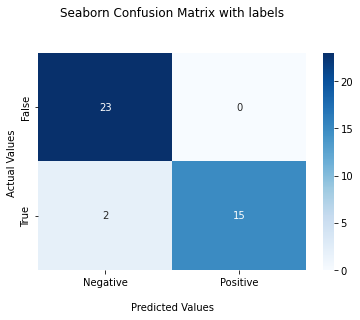

In [ ]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = prediction.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
cf_matrix = metrics.confusionMatrix().toArray()
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()